# Using LX-Parser to parse sentences and displaying constituency trees
This is an example notebook that illustrates how you can use the LX-Parser web service to parse 
sentences.

**Before you run this example**, replace `access_key_goes_here` by your webservice access key, below:

In [1]:
LXPARSER_WS_API_KEY = 'access_key_goes_here'
LXPARSER_WS_API_URL = 'https://portulanclarin.net/workbench/lx-parser/api/'

## Importing required Python modules
The next cell will take care of installing the `requests`, `nltk` and `svgling` packages,
if not already installed, and make them available to use in this notebook.

In [2]:
try:
    import requests
except:
    !pip3 install requests
    import requests
try:
    import nltk.tree
except:
    !pip3 install nltk
    import nltk.tree
try:
    import svgling
except:
    !pip3 install svgling
    import svgling

import IPython.display

## Wrapping the complexities of the JSON-RPC API in a simple, easy to use function

The `WSException` class defined below, will be used later to identify errors
from the webservice.

In [3]:
class WSException(Exception):
    'Webservice Exception'
    def __init__(self, errordata):
        "errordata is a dict returned by the webservice with details about the error"
        super().__init__(self)
        assert isinstance(errordata, dict)
        self.message = errordata["message"]
        # see https://json-rpc.readthedocs.io/en/latest/exceptions.html for more info
        # about JSON-RPC error codes
        if -32099 <= errordata["code"] <= -32000:  # Server Error
            if errordata["data"]["type"] == "WebServiceException":
                self.message += f": {errordata['data']['message']}"
            else:
                self.message += f": {errordata['data']!r}"
    def __str__(self):
        return self.message

The next function invoques the LX-Suite webservice through it's public JSON-RPC API.

In [4]:
def parse(text, format):
    '''
    Arguments
        text: a string with a maximum of 2000 characters, Portuguese text, with
             the input to be processed
        format: either 'parentheses', 'table' or 'JSON'

    Returns a string or JSON object with the output according to specification in
       https://portulanclarin.net/workbench/lx-parser/
    
    Raises a WSException if an error occurs.
    '''

    request_data = {
        'method': 'parse',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'text': text,
            'format': format,
            'key': LXPARSER_WS_API_KEY,
        },
    }
    request = requests.post(LXPARSER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

Let us test the function we just defined:

In [5]:
text = '''Esta frase serve para testar o funcionamento do parser de constituência. Esta outra
frase faz o mesmo.'''
# the parentheses format (aka bracketed format) is a popular format for representing
# constituency trees
result = parse(text, format="parentheses")
print(result)

(ROOT (S (S (NP (DEM Esta) (N frase)) (VP (V' (V serve) (PP (P para) (NP (N testar)))) (NP (ART o) (N' (N funcionamento) (PP (P de_) (NP (ART o) (N' (N parser) (PP (P de) (NP (N constituência)))))))))) (PNT .)))
(ROOT (S (S (NP (DEM Esta) (N' (A outra) (N frase))) (VP (V faz) (NP (ART o) (N' (A mesmo))))) (PNT .)))


Let us use the `svgling` for displaying constituency trees:

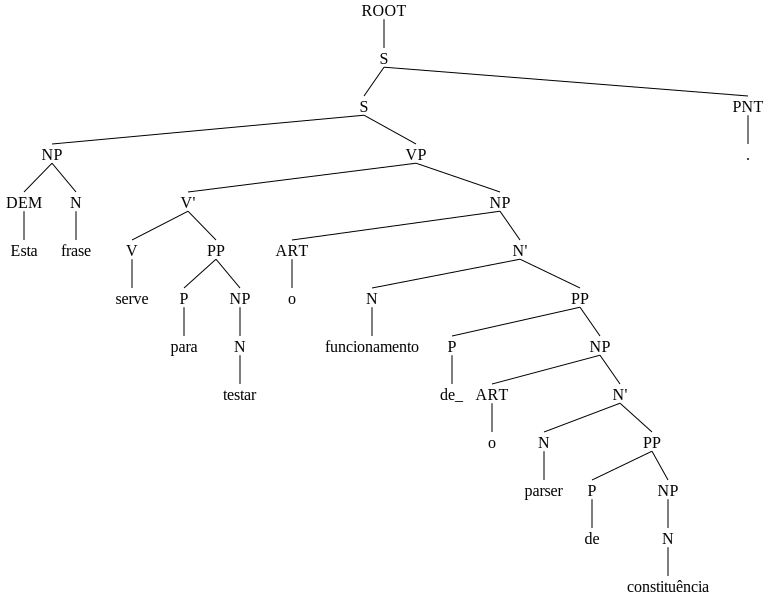

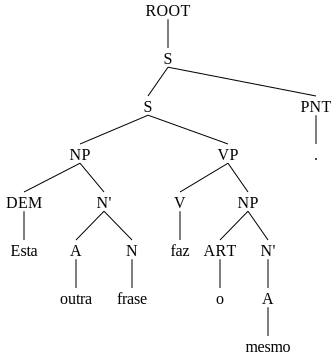

In [6]:
for sentence in result.splitlines(keepends=False):
    tree = nltk.tree.Tree.fromstring(sentence)
    IPython.display.display(svgling.draw_tree(tree))


## Getting the status of a webservice access key

In [7]:
def get_key_status():
    '''Returns a string with the detailed status of the webservice access key'''
    
    request_data = {
        'method': 'key_status',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'key': LXPARSER_WS_API_KEY,
        },
    }
    request = requests.post(LXPARSER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

In [8]:
get_key_status()

{'requests_remaining': 99999978,
 'chars_remaining': 999998761,
 'expiry': '2030-01-10T00:00+00:00'}